# A versatile classification tool for galactic activity using optical and infrared colors

This notebook classifies galaxies based on their activity into five classes: star-forming, AGN, LINER, composite, and passive based on the paper "*A versatile classification tool for galactic activity using optical and
infrared colors*"
and is organised into 5 sections (0 to 4) as follows: <br> <br>
**Section 0:** Contains all the important Python packages as well as useful functions for the classification process.  <br>
**Section 1:** The user loads a catalog of galaxies for classification (fits or csv format). In this section, the user should also define the names of the columns that have the g- and r-band photometry. For the column names of the WISE apertures (_w*gmag_ and _w*mag_2_, where * coresponds to 1,2, and 3 WISE bands) we assume that the names follow the WISE naming convention (see [AllWISE Source Catalog and Reject Table](https://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html), for a detailed description of the WISE apertures). <br>
**Section 2:** Calculation of the hybrid photometric scheme which is based on a combination of the _w*gmag_ and _w*mag_2_ WISE apertures. <br>
**Section 3:** Selection of galaxies that satisfies the signal-to-noise criteria set during the definision of the dignostic. Also any galaxy that its photometry has been flagged as unrealiable (for more details see section 2.4 of the paper and the [AllWISE Source Catalog and Reject Table](https://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html)). <br>
**Section 4:** Implementation of the classifier on the clean sample of galaxies. <br> 
**Section 5:** Exportation of a file containing a column named 'Classification' with the activity class of each galaxy in the catalog provided by the user. For convinience we code the classification output using numbers for each activity class. We also provide the RF-predicted probabilities for every object to belong to each activity class. Below we provide a legend with the meaning of the classification output. <br> <br>
**Classification legend** <br>
0 - star forming <br>
1 - AGN <br>
2 - LINER <br>
3 - composite <br>
4 - passive <br>

<hr style="border:1px solid black">

##  0 - Imports and functions

You don't have to change anything in this section

In [80]:
from sklearn.ensemble import RandomForestClassifier
from astropy.io import fits 
from astropy.table import Table
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import csv
import os

In [50]:
# Function that loads the catalog (file) that contains the galaxies to be classified
def load_file(name, file_format):
    """
    Load a file based on the given format.

    Parameters:
        name (str): The base name of the file (without extension).
        file_format (str): The format of the file, either 'csv' or 'fits'.

    Returns:
        pandas.DataFrame
    """
    if file_format=='csv':
        df = pd.read_csv(name+'.csv')
    elif file_format=='fits':
        dat = Table.read(name+'.fits', format='fits')
        df = dat.to_pandas()
    return df

In [51]:
# Function to save the file with the galaxies containing their activity classification as a separate column
def save_cat(df_c, cat_name, cat_format):
    """
    Save a catalog to a file in the specified format.

    Parameters:
        cat_name (str): The name of the file to be saved (without extension).
        cat_format (str): The format in which the catalog should be saved. Supported formats: 'fits' and 'csv'.

    Returns:
        None
    """
    if (cat_format=='fits'):
        new_t = Table.from_pandas(df_c)
        new_t.write(cat_name+'.fits')
    elif (cat_format=='csv'): 
        df_c.to_csv(cat_name+'.csv',index=False)
    else :
        return

In [52]:
# Function for cleaning the galaxy sample based on Sginal-to-Noise ratio
def SN_clean(dfr, band, Noise, SN):
    """
    Clean the DataFrame of galaxies based on the signal-to-noise (SN) threshold for a specific band.

    Parameters:
        dfr (pandas.DataFrame): The DataFrame containing galaxy data.
        band (str): The name of the band (column) in the DataFrame to be used for cleaning (mags).
        Noise (str): The name of the column that contains the measurement error in a band (mags).
        SN (float): The signal-to-noise threshold. Galaxies with values below this threshold will be removed.

    Returns:
        pandas.DataFrame: The cleaned DataFrame containing only galaxies with signal-to-noise greater than SN.
        
    Example:
        SN_clean(df, 'g', 'g_err', 3.0)  # This will remove galaxies with signal-to-noise less than 3.0 in the g-band.
    """
    dfr.reset_index(inplace=True,drop=True)
    dfr.loc[:,band+'_SN'] = (1.087)/dfr[Noise].astype(float)
    print('Galaxies before cleaning '+band+': ',len(dfr))
    dfr = dfr.loc[(dfr.index[np.where((dfr[band+'_SN'] > SN))].tolist())]
    print('Galaxies after cleaning ' +band+' :',len(dfr))
    return dfr

In [53]:
# Function for dropping no detectoions in WISE bands 
def drop_no_detections(dfr, band_err):
    """
    Drop galaxies from the DataFrame that have no detections or invalid values in the specified 'band_err' column.

    Parameters:
        dfr (pandas.DataFrame): The DataFrame containing galaxy data.
        band_err (str): The name of the column representing the measurement error in the corresponding band.

    Returns:
        pandas.DataFrame: The DataFrame with galaxies removed based on the error flags.
    """
    dfr.reset_index(inplace=True,drop=True)
    print('Galaxies brfore: ',len(dfr))
    df_cln = dfr.drop(dfr.index[np.where((dfr[band_err].isna()) | (dfr[band_err]==9.999))].tolist())
    print('Galaxies after dropping no detections: ', len(df_cln))
    return df_cln

In [54]:
# Function for dropping cc_flags in WISE band
def drop_cc_flags(dfr):
    """
    Drop galaxies from the DataFrame based on specific values in the 'cc_flags' column.

    Parameters:
        dfr (pandas.DataFrame): The DataFrame containing galaxy data.

    Returns:
        pandas.DataFrame: The DataFrame with galaxies removed based on 'cc_flags' values.
    """
    dfr.reset_index(inplace=True,drop=True)
    print('Galaxies brfore: ',len(dfr))
    df_cln = dfr.loc[(dfr.index[np.where((dfr['cc_flags']=='000D') | (dfr['cc_flags']=='000P') | (dfr['cc_flags']=='0000') | (dfr['cc_flags']=='000O') | (dfr['cc_flags']=='000o') | (dfr['cc_flags']=='000H') | (dfr['cc_flags']=='000h') | (dfr['cc_flags']=='000p') | (dfr['cc_flags']=='000d'))].tolist())]
    print('Galaxies after no detections drop: ', len(df_cln))
    return df_cln

In [55]:
# Function for dropping upper limits in WISE bands
def drop_upper(dfr, band_gflag, band_flag):
    """
    Drop galaxies from the DataFrame based on specific conditions related to 'w*gflg' and 'w*flg_2' columns.

    Parameters:
        dfr (pandas.DataFrame): The DataFrame containing galaxy data.
        band_gflag (str): The name of the column representing the galaxy flags for 'w*gflg'.
        band_flag (str): The name of the column representing the galaxy flags for 'w*flg_2'.

    Returns:
        pandas.DataFrame: The DataFrame with galaxies removed based on specific conditions.
    """
    dfr.reset_index(inplace=True,drop=True)
    print('Galaxies brfore: ',len(dfr))
    df_cln = dfr.loc[(dfr.index[np.where((dfr[band_gflag]!=32) & (dfr[band_flag]!=32))].tolist())]
    print('Galaxies after dropping no detections: ', len(df_cln))
    return df_cln

In [56]:
# Function to calculate the hybrid photometry in WISE bands 
def calc_hybrid_phot(df, column_name):
    df[f"{column_name}_hyb"] = df[f"{column_name}gmag"].fillna(df[f"{column_name}mag_2"])
    return df

In [57]:
# Function to calculate the error in hybrid photometry in WISE bands 
def calc_hybrid_phot_error(df, column_name):
    df[f"{column_name}_hyb_err"] = df[f"{column_name}gerr"].fillna(df[f"{column_name}sigm_2"])
    return df

In [58]:
# Function to calculate the colors of hybrid photometry in WISE bands 
def calc_wise_colors(df, column1, column2):
    df[f"{column1}_hyb-{column2}_hyb"] = df[f"{column1}_hyb"] - df[f"{column2}_hyb"]
    return df

<hr style="border:1px solid black">

## 1 - Load catalog and define column names of g- and r-bands

Change the path to load your catalog accordingly.

In [59]:
cat = load_file('your_path/sample_activity_classifier','csv')

Change the names of the g- and r-bands with the ones from your dataset in the cell below.

In [60]:
### Give the column name of the g- and r- band photometry as well as the column name of their corresponding error
gband = 'fiberMag_g'
rband = 'fiberMag_r'

gband_err = 'fiberMagErr_g'
rband_err = 'fiberMagErr_r'

## 2 - WISE hybrid photomery calculation

Below we apply the functions (defined in section 0) to calculate the hybrid WISE photometry (see section 2.2 of the paper).

In [61]:
cat = calc_hybrid_phot(cat, 'w1')
cat = calc_hybrid_phot(cat, 'w2')
cat = calc_hybrid_phot(cat, 'w3')

In [62]:
cat = calc_hybrid_phot_error(cat, 'w1')
cat = calc_hybrid_phot_error(cat, 'w2')
cat = calc_hybrid_phot_error(cat, 'w3')

In [63]:
cat = calc_wise_colors(cat, 'w1', 'w2')
cat = calc_wise_colors(cat, 'w2', 'w3')
cat['g-r'] = cat[gband] - cat[rband]

## 3 - Unreliable photometry removal and signal-to-noise cuts

Here we clean the sample (see section 2.4 of paper)

Signal-to-noise cleaning of the galaxies:

In [64]:
cat = SN_clean(cat, 'w1_hyb', 'w1_hyb_err', 5)
cat = SN_clean(cat, 'w2_hyb', 'w2_hyb_err', 5)
cat = SN_clean(cat, 'w3_hyb', 'w3_hyb_err', 3)

cat = SN_clean(cat, gband, gband_err, 5)
cat = SN_clean(cat, rband, rband_err, 5)

Galaxies before cleaning w1_hyb:  500
Galaxies after cleaning w1_hyb : 500
Galaxies before cleaning w2_hyb:  500
Galaxies after cleaning w2_hyb : 500
Galaxies before cleaning w3_hyb:  500
Galaxies after cleaning w3_hyb : 486
Galaxies before cleaning fiberMag_g:  486
Galaxies after cleaning fiberMag_g : 450
Galaxies before cleaning fiberMag_r:  450
Galaxies after cleaning fiberMag_r : 450


Drop objects with non-detections:

In [65]:
cat = drop_no_detections(cat,'w1_hyb_err')
cat = drop_no_detections(cat,'w2_hyb_err')
cat = drop_no_detections(cat,'w3_hyb_err')

Galaxies brfore:  450
Galaxies after dropping no detections:  450
Galaxies brfore:  450
Galaxies after dropping no detections:  450
Galaxies brfore:  450
Galaxies after dropping no detections:  450


Drop objects with upper limits:

In [66]:
cat = drop_upper(cat, 'w1gflg', 'w1flg_2')
cat = drop_upper(cat, 'w2gflg', 'w2flg_2')
cat = drop_upper(cat, 'w3gflg', 'w3flg_2')

Galaxies brfore:  450
Galaxies after dropping no detections:  450
Galaxies brfore:  450
Galaxies after dropping no detections:  450
Galaxies brfore:  450
Galaxies after dropping no detections:  450


Drop objects with cc_flags:

In [67]:
cat = drop_cc_flags(cat)

Galaxies brfore:  450
Galaxies after no detections drop:  429


Drop objects with null values in any of the features:

In [68]:
cat.dropna(subset=['w1_hyb-w2_hyb', 'w2_hyb-w3_hyb', 'g-r'],inplace=True)

## 4 - Implementation of the RF

Here we apply the RF classifier on the clean sample of galaxies. <br> Change the path to where you have stored the RF model.

In [69]:
# Application of the cassifier on the catalog
RF_WISE_classifier = 'your_path/RF_model_W1W2_W2W3_gr_gl.sav'
clf = joblib.load(RF_WISE_classifier)

cat.loc[:,'Classification'] = clf.predict(cat[['w1_hyb-w2_hyb','w2_hyb-w3_hyb','g-r']].values)
cat['Classification'] = cat['Classification'].astype(int)
cat[['prob_SFG','prob_AGN','prob_LINER','prob_COMP','prob_Passive']] = clf.predict_proba(cat[['w1_hyb-w2_hyb','w2_hyb-w3_hyb','g-r']].values)

C:\Users\babis\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\babis\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


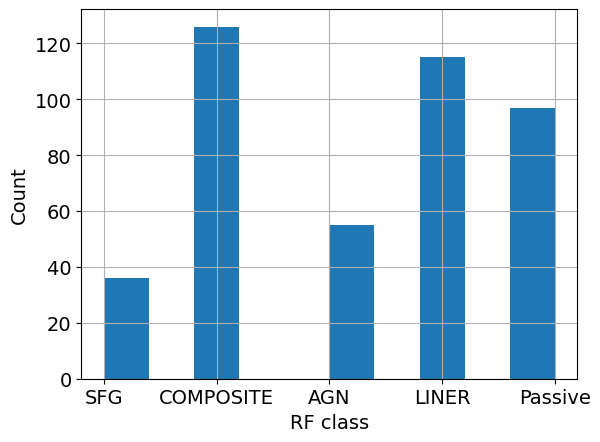

In [78]:
cat['Classification'].replace({0: 'SFG', 1: 'AGN', 2: 'LINER', 3: 'COMPOSITE', 4: 'Passive'},inplace=True)
cat['Classification'].hist()
plt.xlabel('RF class',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

<hr style="border:1px solid black">

## 5 - Export catalog with classifications

The following cell exports the dataset of the clean galaxies with added columns for the activity class as well as their RF-predicted probabilities of galaxies to a *csv* or *fits* file 

In [71]:
# save_cat(cat, '/your_path/catalog_name','csv')